In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, AveragePooling2D, Flatten, Dense, BatchNormalization, Activation, Add, AveragePooling2D 
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.decomposition import PCA
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
%matplotlib inline

In [2]:
train_dir = '/Users/lks/Desktop/VIT/Project/EPICS Project/data/train'
val_dir = '/Users/lks/Desktop/VIT/Project/EPICS Project/data/val'
test_dir = '/Users/lks/Desktop/VIT/Project/EPICS Project/data/test'

In [3]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=42,
    image_size= (250, 250),
    batch_size=100
)

Found 889 files belonging to 2 classes.


In [4]:
training_ds.class_names

['Accident', 'Non Accident']

In [5]:
validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=42,
    image_size= (250, 250),
    batch_size=100)

Found 98 files belonging to 2 classes.


In [6]:
testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=42,
    image_size= (250, 250),
    batch_size= 100)

Found 100 files belonging to 2 classes.


In [7]:
actual_value = []
for images, batch_labels in testing_ds:
    actual_value.extend(batch_labels.numpy())
    
actual_value

[0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1]

In [8]:
def alex_net(model):
    model.add(tf.keras.layers.Conv2D(filters= 96, kernel_size= (11, 11), 
                                     activation= 'relu', strides= (4, 4), 
                                     input_shape= (250, 250, 3)))
    model.add(tf.keras.layers.MaxPooling2D(3, 3))
    model.add(tf.keras.layers.Conv2D(filters= 256, kernel_size= (5, 5), 
                                     activation= 'relu', padding= 'same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size= (3, 3), strides= (2, 2)))
    model.add(tf.keras.layers.Conv2D(filters= 384, kernel_size= (3, 3), 
                                     activation= 'relu', padding= 'same'))
    model.add(tf.keras.layers.Conv2D(filters= 384, kernel_size= (3, 3), 
                                     activation= 'relu', padding= 'same'))
    model.add(tf.keras.layers.Conv2D(filters= 256, kernel_size= (3, 3), 
                                     activation= 'relu', padding= 'same'))
    model.add(tf.keras.layers.Flatten())

In [9]:
def inception_module(x, filters):
    tower_1 = Conv2D(filters[0], (1,1), padding='same', activation='relu')(x)
    tower_1 = Conv2D(filters[1], (3,3), padding='same', activation='relu')(tower_1)

    tower_2 = Conv2D(filters[2], (1,1), padding='same', activation='relu')(x)
    tower_2 = Conv2D(filters[3], (5,5), padding='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    tower_3 = Conv2D(filters[4], (1,1), padding='same', activation='relu')(tower_3)

    output = concatenate([tower_1, tower_2, tower_3], axis=3)
    return output

In [10]:
def google_net():
    input_layer_google = Input(shape=(250, 250, 3))
    
    x = Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(input_layer_google)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = Conv2D(64, (1,1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3,3), padding='same', activation='relu')(x)
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = inception_module(x, [64, 96, 128, 16, 32])
    x = inception_module(x, [128, 128, 192, 32, 96])
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48])
    x = inception_module(x, [160, 112, 224, 24, 64])
    x = inception_module(x, [128, 128, 256, 24, 64])
    x = inception_module(x, [112, 144, 288, 32, 64])
    x = inception_module(x, [256, 160, 320, 32, 128])
    x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128])
    x = inception_module(x, [384, 192, 384, 48, 128])

    x = AveragePooling2D((7,7), strides=(7,7))(x)
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1000, activation= 'linear')(x)
    output_layer_google = Dense(2, activation='softmax')(x)
    
    return Model(inputs=input_layer_google, outputs=output_layer_google)
    

In [11]:
def CNN_model(model):
    model.add(tf.keras.layers.Conv2D(32, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides= (2, 2)))
    model.add(tf.keras.layers.Conv2D(64, 3, activation='relu', padding= 'same'))
    model.add(tf.keras.layers.MaxPooling2D((1, 1), strides= (4, 4)))
    model.add(tf.keras.layers.Conv2D(128, 3, activation='relu', padding= 'same'))
    model.add(tf.keras.layers.MaxPooling2D())
    model.add(tf.keras.layers.Flatten())

In [12]:
model1 = tf.keras.models.Sequential()

alex_net(model1)

model1.add(tf.keras.layers.Dense(4096, activation= 'tanh'))
model1.add(tf.keras.layers.Dropout(rate= 0.5))
model1.add(tf.keras.layers.Dense(4096, activation= 'relu'))
model1.add(tf.keras.layers.Dropout(rate= 0.5))
model1.add(tf.keras.layers.Dense(2, activation= 'softmax'))

model1.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

model1_val = model1.fit(training_ds, epochs= 25, validation_data= (validation_ds))

Epoch 1/25
9/9 [==============================] - 7s 571ms/step - loss: 11.2025 - accuracy: 0.4961 - val_loss: 0.7404 - val_accuracy: 0.5306
Epoch 2/25
9/9 [==============================] - 6s 557ms/step - loss: 0.7835 - accuracy: 0.4994 - val_loss: 0.6950 - val_accuracy: 0.4694
Epoch 3/25
9/9 [==============================] - 6s 555ms/step - loss: 0.7003 - accuracy: 0.5276 - val_loss: 0.6913 - val_accuracy: 0.5306
Epoch 4/25
9/9 [==============================] - 6s 552ms/step - loss: 0.6945 - accuracy: 0.5084 - val_loss: 0.6912 - val_accuracy: 0.5306
Epoch 5/25
9/9 [==============================] - 6s 534ms/step - loss: 0.6910 - accuracy: 0.5309 - val_loss: 0.6915 - val_accuracy: 0.5306
Epoch 6/25
9/9 [==============================] - 6s 550ms/step - loss: 0.6911 - accuracy: 0.5298 - val_loss: 0.6920 - val_accuracy: 0.5306
Epoch 7/25
9/9 [==============================] - 6s 558ms/step - loss: 0.6916 - accuracy: 0.5388 - val_loss: 0.6913 - val_accuracy: 0.5306
Epoch 8/25
9/9 [===

In [14]:
test_loss1, test_accuracy1 = model1.evaluate(testing_ds)
y_alex_pred = model1.predict(testing_ds)
y_alex_pred = [np.argmax(e) for e in y_alex_pred]

print(f"Top-1 accuracy: {1 - test_accuracy1}")

1/1 [==============================] - 0s 173ms/step
Top-1 accuracy: 0.4700000286102295


In [15]:
model2 = google_net()

model2.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

model2_val = model2.fit(training_ds, epochs= 50, validation_data= (validation_ds))


Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: 11.4342 - accuracy: 0.5321 - val_loss: 0.6948 - val_accuracy: 0.4694
Epoch 2/50
9/9 [==============================] - 14s 1s/step - loss: 0.6981 - accuracy: 0.4983 - val_loss: 0.6912 - val_accuracy: 0.5306
Epoch 3/50
9/9 [==============================] - 14s 1s/step - loss: 0.6935 - accuracy: 0.5197 - val_loss: 0.6911 - val_accuracy: 0.5306
Epoch 4/50
9/9 [==============================] - 14s 1s/step - loss: 0.6941 - accuracy: 0.5298 - val_loss: 0.6914 - val_accuracy: 0.5306
Epoch 5/50
9/9 [==============================] - 14s 1s/step - loss: 0.6921 - accuracy: 0.5287 - val_loss: 0.6914 - val_accuracy: 0.5306
Epoch 6/50
9/9 [==============================] - 14s 1s/step - loss: 0.6927 - accuracy: 0.5298 - val_loss: 0.6915 - val_accuracy: 0.5306
Epoch 7/50
9/9 [==============================] - 14s 1s/step - loss: 0.6919 - accuracy: 0.5332 - val_loss: 0.6913 - val_accuracy: 0.5306
Epoch 8/50
9/9 [=================

In [16]:
test_loss2, test_accuracy2 = model2.evaluate(testing_ds)
y_google_pred = model2.predict(testing_ds)
y_google_pred = [np.argmax(e) for e in y_google_pred]

print(f"Top-1 error rate: {1 - test_accuracy2}")

1/1 [==============================] - 2s 2s/step
Top-1 error rate: 0.4700000286102295


In [17]:
model3 = tf.keras.models.Sequential()

CNN_model(model3)

model3.add(tf.keras.layers.Dense(256, activation='relu'))
model3.add(tf.keras.layers.Dense(2, activation= 'softmax'))

model3.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model3_val = model3.fit(training_ds, validation_data= validation_ds, epochs = 50)

Epoch 1/50
9/9 [==============================] - 14s 1s/step - loss: 207.0384 - accuracy: 0.5118 - val_loss: 6.6586 - val_accuracy: 0.4694
Epoch 2/50
9/9 [==============================] - 13s 1s/step - loss: 1.9168 - accuracy: 0.5174 - val_loss: 0.5748 - val_accuracy: 0.6837
Epoch 3/50
9/9 [==============================] - 12s 1s/step - loss: 0.6384 - accuracy: 0.6400 - val_loss: 0.5374 - val_accuracy: 0.7551
Epoch 4/50
9/9 [==============================] - 12s 1s/step - loss: 0.5495 - accuracy: 0.7132 - val_loss: 0.4361 - val_accuracy: 0.8469
Epoch 5/50
9/9 [==============================] - 13s 1s/step - loss: 0.4618 - accuracy: 0.7852 - val_loss: 0.3134 - val_accuracy: 0.9082
Epoch 6/50
9/9 [==============================] - 13s 1s/step - loss: 0.3650 - accuracy: 0.8414 - val_loss: 0.2381 - val_accuracy: 0.8980
Epoch 7/50
9/9 [==============================] - 13s 1s/step - loss: 0.2811 - accuracy: 0.8909 - val_loss: 0.2335 - val_accuracy: 0.9388
Epoch 8/50
9/9 [================

In [18]:
test_loss3, test_accuracy3 = model3.evaluate(testing_ds)
y_cnn_pred = model3.predict(testing_ds)
y_cnn_pred = [np.argmax(e) for e in y_cnn_pred]

print(f"Top-1 error rate: {1 - test_accuracy3}")

1/1 [==============================] - 1s 619ms/step
Top-1 error rate: 0.06999999284744263


In [19]:
image = cv2.imread('/Users/lks/Desktop/VIT/Project/Epics Project/Application/static/accident_image.jpeg')
image = cv2.resize(image, (250, 250))  # Resize the image to match the model's input size
image = image.astype('float32') / 255.0
image = np.expand_dims(image, axis=0)

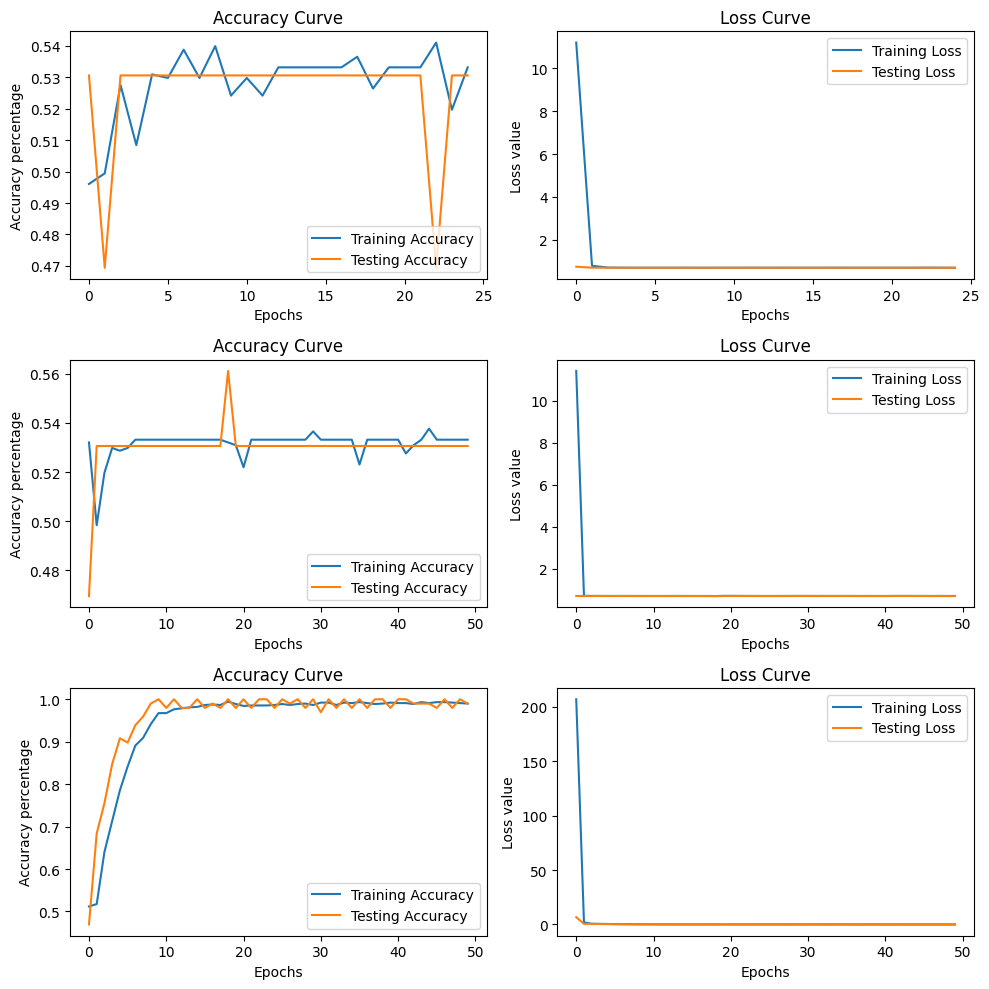

In [20]:
fig, ax = plt.subplots(nrows= 3, ncols= 2, figsize= (10, 10))
models = [model1_val, model2_val, model3_val]

for i in range(3):
    ax[i, 0].plot(models[i].epoch, models[i].history['accuracy'], label= 'Training Accuracy')
    ax[i, 0].plot(models[i].epoch, models[i].history['val_accuracy'], label= 'Testing Accuracy')
    ax[i, 0].set_title('Accuracy Curve')
    ax[i, 0].legend(loc= 'lower right')
    ax[i, 0].set(xlabel= 'Epochs', ylabel= 'Accuracy percentage')
    
    ax[i, 1].plot(models[i].epoch, models[i].history['loss'], label= 'Training Loss')
    ax[i, 1].plot(models[i].epoch, models[i].history['val_loss'], label= 'Testing Loss')
    ax[i, 1].set_title('Loss Curve')
    ax[i, 1].legend(loc= 'upper right')
    ax[i, 1].set(xlabel= 'Epochs', ylabel= 'Loss value')
    
fig.tight_layout()
plt.show()
    

In [21]:
class_names = training_ds.class_names

In [22]:
def confusion_matrix_plot(cm, class_names, model):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix of {model}")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center", color= 'black')
        
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

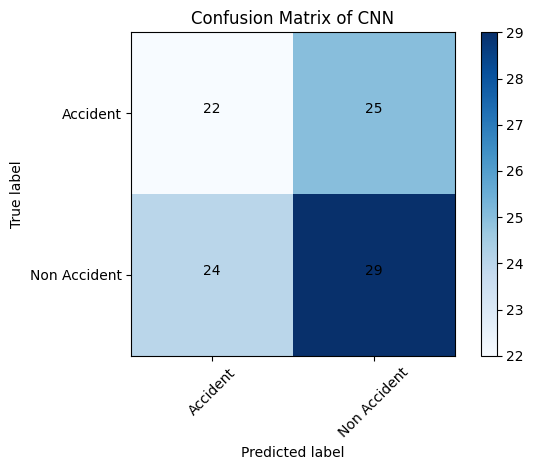

In [23]:
from sklearn.metrics import confusion_matrix

cm_alexnet = confusion_matrix(actual_value, y_alex_pred)
cm_google = confusion_matrix(actual_value, y_google_pred)
cm_cnn = confusion_matrix(actual_value, y_cnn_pred)

cms = {'AlexNet': cm_alexnet,
      'GoogLeNet': cm_google, 
      'CNN': cm_cnn}

confusion_matrix_plot(cm_cnn, class_names, 'CNN')

In [24]:
class_names[np.argmax(model1.predict(image))]

1/1 [==============================] - 0s 345ms/step


'Non Accident'

In [25]:
class_names[np.argmax(model2.predict(image))]

1/1 [==============================] - 1s 1s/step


'Non Accident'

In [26]:
class_names[np.argmax(model3.predict(image))]

1/1 [==============================] - 0s 128ms/step


'Non Accident'

pickle.dump(model3, open('CCD.pkl', 'wb'))